In [17]:
import pandas as pd
import re
import string
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [18]:
data = pd.read_csv("tweets.csv")

print("Columns in dataset:", data.columns)

Columns in dataset: Index(['author', 'content', 'country', 'date_time', 'id', 'language',
       'latitude', 'longitude', 'number_of_likes', 'number_of_shares'],
      dtype='object')


In [19]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove links
    text = re.sub(r"\@\w+|\#", "", text)                 # remove mentions & hashtags
    text = text.translate(str.maketrans("", "", string.punctuation))  # remove punctuation
    text = re.sub(r"\d+", "", text)                      # remove numbers
    text = re.sub(r"\s+", " ", text).strip()             # remove extra spaces
    return text

# --- Apply Cleaning ---
data["clean_tweet"] = data["content"].apply(clean_text)

In [20]:
data["sentiment_score"] = data["clean_tweet"].apply(lambda x: TextBlob(x).sentiment.polarity)
data["label"] = data["sentiment_score"].apply(lambda x: 1 if x > 0 else 0)

print("\nSample Data with Labels:\n", data[["clean_tweet", "sentiment_score", "label"]].head())


Sample Data with Labels:
                                          clean_tweet  sentiment_score  label
0       is history repeating itselfdontnormalizehate         0.000000      0
1  thank you for your incredible grace in leaders...         0.900000      1
2                                         life goals         0.000000      0
3                                    me right now 🙏🏻         0.285714      1
4          sisters are doin it for themselves 🙌🏻💪🏻❤️         0.000000      0


In [21]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(data["clean_tweet"]).toarray()
y = data["label"]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [24]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

In [25]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))


Accuracy: 0.9430963935674184

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      5705
           1       0.96      0.91      0.94      4804

    accuracy                           0.94     10509
   macro avg       0.95      0.94      0.94     10509
weighted avg       0.94      0.94      0.94     10509


ROC AUC Score: 0.9815003893191548


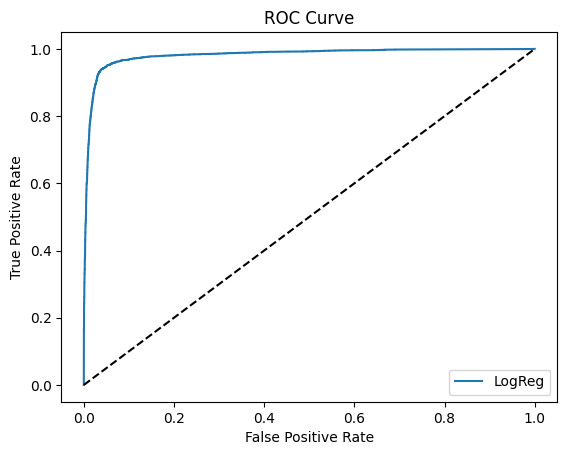

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="LogReg")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()